In [1]:
from src.motion_models.trajectory_generation.route_generation import *
from src.visual.visual_tools import *

import numpy as np

%load_ext autoreload
%autoreload 2

Estimating R
True R should be: [[0.04 0.  ]
 [0.   0.04]]
Initial R: [[100   0]
 [  0 100]]
R : [[7.47478163e+01 2.57226700e-03]
 [2.57226700e-03 7.47494020e+01]]
R : [[5.59871279e+01 4.89198283e-03]
 [4.89198283e-03 5.59860190e+01]]
R : [[4.20220190e+01 4.94787529e-03]
 [4.94787529e-03 4.20204839e+01]]
R : [[3.16129305e+01 2.33464484e-03]
 [2.33464484e-03 3.16109111e+01]]
R : [[2.38409643e+01 1.69303293e-03]
 [1.69303293e-03 2.38370219e+01]]
R : [[1.80264540e+01 2.60557556e-03]
 [2.60557556e-03 1.80219611e+01]]
R : [[1.36665042e+01 1.42667619e-03]
 [1.42667619e-03 1.36652493e+01]]
R : [[1.03899292e+01 1.18042564e-03]
 [1.18042564e-03 1.03914394e+01]]
R : [[7.92845081e+00 9.16958380e-05]
 [9.16958380e-05 7.92492003e+00]]
R : [[6.06869457e+00 1.83262780e-03]
 [1.83262780e-03 6.06601065e+00]]
R : [[4.66180834e+00 1.74523368e-03]
 [1.74523368e-03 4.65964016e+00]]
R : [[ 3.59672741e+00 -7.79200370e-05]
 [-7.79200370e-05  3.59485567e+00]]
R : [[ 2.78565666e+00 -1.16286963e-03]
 [-1.16286963

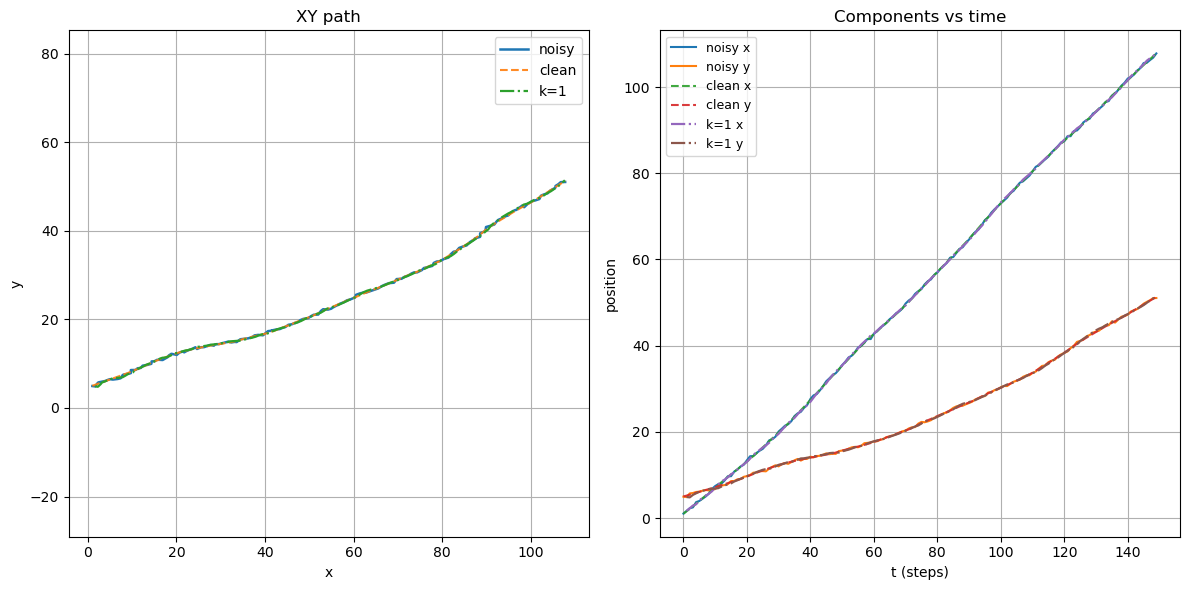

In [11]:
from src.filters import InitializationData, CVKalmanFilter

REAL_NOISE = np.array([0.2, 0.2])
REAL_PROCESS_NOISE_STD = np.array([0.5,0.5])
dt=0.04
white_accel_density = 1e1

initial_velocity = np.array([14,5])
initial_position = np.array([1,5])

# Generate trajectories with the real noise
initial_trajectory_state = TrajectoryState(position=initial_position, velocity=initial_velocity)
trajectories = generate_cv_trajectory(T=150, dt=dt, initial_state=initial_trajectory_state, number_of_trajectories=40, measurement_noise_std=REAL_NOISE, vel_change_std=REAL_PROCESS_NOISE_STD, seed=44)

test_traj = trajectories[0][0]
clean_test_traj = trajectories[0][1]

# Initialize the noise std with large unkonwn value
INITIAL_NOISE = np.array([10, 10])
INITIAL_PROCESS_NOISE_STD = np.array([10,10])

# Initialzing the KF
initial_matrices_data = InitializationData(observation_noise_std=INITIAL_NOISE, process_noise_std=INITIAL_PROCESS_NOISE_STD)
kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)
kf.initialize()

# R fitting with fixed old_em method
print("Estimating R")
print(f"True R should be: {np.diag(REAL_NOISE**2)}")
print(f"Initial R: {kf.kf.R}")

for i in range(1, 40):
    traj = trajectories[i][0]
    for j in range(3):
        # Estimate R
        res = kf.em(measurements=traj, n_iter=1, estimate_Q=False, estimate_R=True)
    print(f"R : {kf.kf.R}")

print("Estimating Q")
for i in range(1, 40):
    traj = trajectories[i][0]
    
    for j in range(20):
        # Estimate Q
        res = kf.em(measurements=traj, n_iter=1, estimate_Q=True, estimate_R=False)
    print(f"Q : {kf.kf.Q}")


mse, preds= kf.evaluate_on_trajectory(test_traj, clean_test_traj, normalize_mse=False, return_predictions=True)
print(f"Final MSE: {mse}")

plot_trajectories_with_predictions_shifted(noisy=test_traj, clean=clean_test_traj, predictions=[(preds, 1,)])
